# Modelado para la Predicción del Precio de la Vivienda

En este notebook, realizamos la fase de modelado para predecir el precio de las viviendas utilizando varios algoritmos de machine learning.
Los pasos incluyen:
1. Preprocesamiento de datos para el modelado.
2. Entrenamiento de múltiples modelos y evaluación de su rendimiento.
3. Selección del modelo ganador.
4. Identificación de las variables más relevantes en el modelo ganador.


## Importamos librerias y cargamos el dataset

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

In [4]:
# Cargar el dataset limpio
file_path = '../data/processed/cleaned_ofertas_inmobiliarias.csv'
df = pd.read_csv(file_path)

# Mostrar las primeras filas
df.head()



,Precio,Habitaciones,Baños,Parqueos,Sector,Condicion,Uso Actual,mt2,Piso/Nivel,Ascensor,Edificable,Agno Construccion,Planta Electrica,Seguridad 24 Horas,Control de Acceso,Piscina,Gimnasio,Medio baño
0,950.0,1,2,1,El Millón,Segundo Uso,Residencial,73.0,5,True,False,2022,False,False,False,True,True,False
1,10640.0,4,4,5,Av. Anacaona,Segundo Uso,Residencial,611.0,9,True,False,2020,True,True,True,True,True,True
2,10640.0,3,4,4,Av. Anacaona,Segundo Uso,Residencial,598.0,9,True,False,2020,True,True,True,True,True,True
3,10640.0,3,4,2,Av. Anacaona,Segundo Uso,Residencial,598.0,9,True,False,2020,True,True,True,True,True,True
4,10640.0,4,4,4,Av. Anacaona,Nueva,Residencial,615.0,14,True,False,2023,True,True,True,True,False,True


## Estandarizacion 

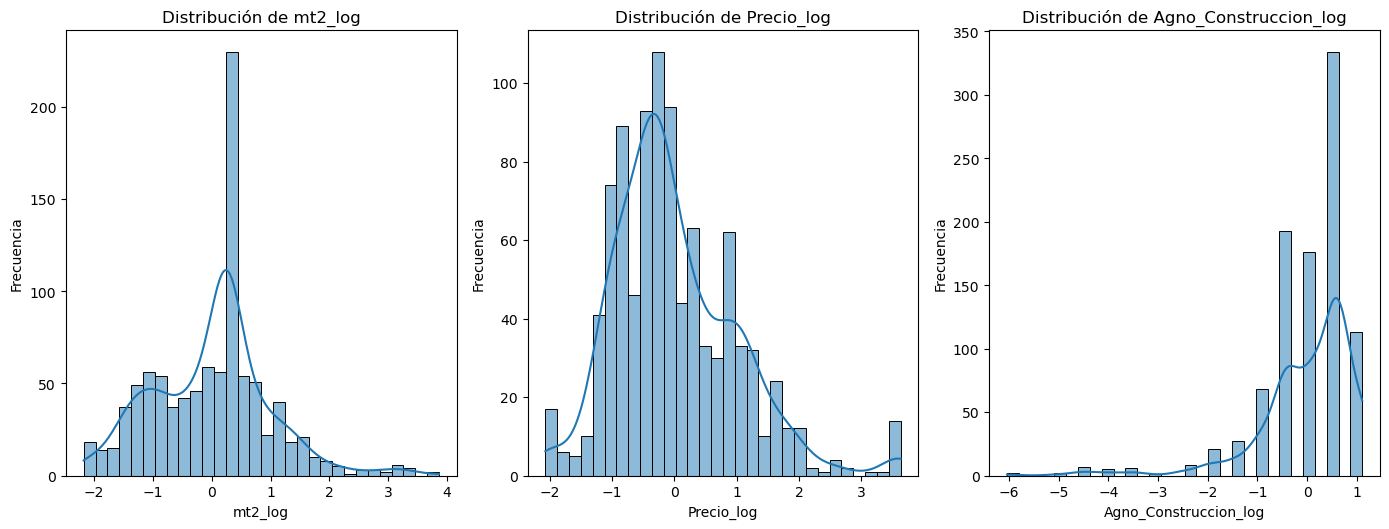

In [5]:
# Filtrar registros para eliminar aquellos con año de construcción anterior a 2010
df = df[df['Agno Construccion'] >= 2010]

# Transformación logarítmica para variables con sesgo
df['mt2_log'] = np.log1p(df['mt2'])
df['Precio_log'] = np.log1p(df['Precio'])
df['Agno_Construccion_log'] = np.log1p(df['Agno Construccion' ])


# Selección de las variables a normalizar
numeric_features = ['mt2_log', 'Precio_log', 'Agno_Construccion_log']
integer_features = ['Piso/Nivel', 'Habitaciones', 'Baños', 'Parqueos']

# Estandarización de las variables transformadas
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])
df[integer_features] = scaler.fit_transform(df[integer_features])


# Configuración de los gráficos
plt.figure(figsize=(14, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribución de {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

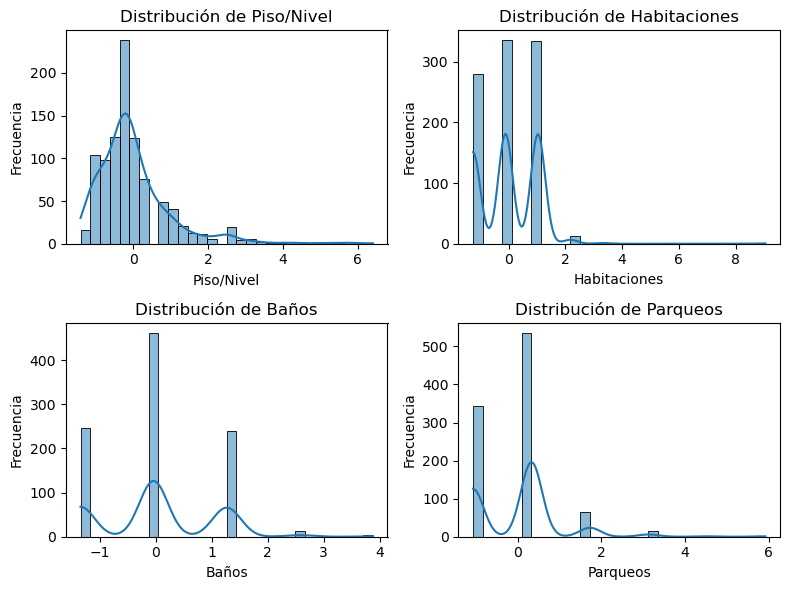

In [6]:
# Configuración del tamaño del gráfico
plt.figure(figsize=(8, 6))

# Graficar las variables enteras estandarizadas como histogramas
for i, feature in enumerate(integer_features, 1):
    plt.subplot(2, 2, i)  # 2x2 grid layout para las 4 variables
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribución de {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()

### Análisis de Estandarización y Distribución
La **estandarización** transforma las variables para tener media 0 y desviación estándar 1, útil para modelos sensibles a la escala como regresión lineal, SVM o redes neuronales.

Observaciones por Variable:
* Piso/Nivel: Sesgo a la izquierda, con más frecuencia en niveles bajos.
* Habitaciones: La mayoría tiene entre 1 y 3 habitaciones; algunos valores atípicos superan las 6.
* Baños: Predominan 1 o 2 baños, con algunos casos más altos.
* Parqueos: Frecuencia concentrada en 0 a 2 parqueos, con algunos valores atípicos.

Conclusión:
* La estandarización es necesaria para modelos basados en distancias (SVM, regresión).
* Para árboles de decisión o random forest, no es requerida y las variables pueden usarse sin escalar.

## Seleccion de variables

Revisar los p values de las variables independientes. Anova del modelo. Prueba de autoregresion de los residuos

## Modelado

In [7]:
# Seleccionar las variables predictoras y la variable objetivo
X = df.drop(['Precio', 'Precio_log'], axis=1)

y = df['Precio_log']

# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Resetear índices para evitar errores al concatenar
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Identificar columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# Definir el preprocesador para variables numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)



print(X_train.shape, X_test.shape)

(770, 19) (193, 19)


In [24]:
# Definir los modelos dentro de pipelines con preprocesamiento integrado
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]),
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('model', DecisionTreeRegressor(random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(random_state=42, verbosity=0))
    ]),
    'ElasticNet': Pipeline([
        ('preprocessor', preprocessor),
        ('model', ElasticNet(random_state=42))
    ]),
    'Support Vector Regressor': Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVR())
    ]),
    'CatBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', CatBoostRegressor(random_state=42, verbose=0))
    ])
}


In [29]:
# Definir scorers para RMSE y R² utilizando la nueva función
rmse_scorer = make_scorer(root_mean_squared_error)
r2_scorer = make_scorer(r2_score)

# Evaluar los modelos con validación cruzada y en los datos de prueba
results = {}
for name, pipeline in models.items():
    # Validación cruzada
    rmse_cv = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=rmse_scorer).mean()
    r2_cv = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=r2_scorer).mean()

    # Entrenar en todo el conjunto de entrenamiento y evaluar en el conjunto de prueba
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Calcular RMSE y R² en el conjunto de prueba
    rmse_test = root_mean_squared_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    # Almacenar resultados
    results[name] = {
        'RMSE (CV)': rmse_cv, 'R² (CV)': r2_cv,
        'RMSE (Test)': rmse_test, 'R² (Test)': r2_test
    }

# Mostrar los resultados de manera clara
for name, scores in results.items():
    print(f"{name}:")
    for metric, score in scores.items():
        print(f"  {metric}: {score:.4f}")
    print()

Linear Regression:
  RMSE (CV): 0.5860
  R² (CV): 0.6651
  RMSE (Test): 0.4732
  R² (Test): 0.7178

Decision Tree:
  RMSE (CV): 0.7657
  R² (CV): 0.4198
  RMSE (Test): 0.6840
  R² (Test): 0.4104

Random Forest:
  RMSE (CV): 0.5574
  R² (CV): 0.6959
  RMSE (Test): 0.4827
  R² (Test): 0.7063

XGBoost:
  RMSE (CV): 0.5921
  R² (CV): 0.6564
  RMSE (Test): 0.4854
  R² (Test): 0.7030

ElasticNet:
  RMSE (CV): 0.9202
  R² (CV): 0.1816
  RMSE (Test): 0.8258
  R² (Test): 0.1405

Support Vector Regressor:
  RMSE (CV): 0.5775
  R² (CV): 0.6738
  RMSE (Test): 0.4740
  R² (Test): 0.7169

CatBoost:
  RMSE (CV): 0.5508
  R² (CV): 0.7044
  RMSE (Test): 0.4569
  R² (Test): 0.7369



In [33]:
# Seleccionar el mejor modelo basado en RMSE (Test)
best_model_name = min(results, key=lambda x: results[x]['RMSE (Test)'])
print(f"El mejor modelo es: {best_model_name}")

El mejor modelo es: CatBoost


Vamos a buscar los mejores hiperparametros para el modelo ganador. Para evitar el sobreajuste

In [32]:
# Definir los hiperparámetros a buscar para CatBoost
param_dist = {
    'model__iterations': [100, 500, 1000],   # Número de iteraciones
    'model__depth': [4, 6, 10],              # Profundidad de los árboles
    'model__learning_rate': [0.01, 0.1, 0.3],  # Tasa de aprendizaje
    'model__l2_leaf_reg': [1, 3, 5]          # Regularización L2
}

# Pipeline del modelo CatBoost (reutilizando preprocesador)
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(random_state=42, verbose=0))
])

# Configuración de RandomizedSearchCV
random_search = RandomizedSearchCV(
    catboost_pipeline,
    param_dist,
    n_iter=20,  # Número de combinaciones aleatorias a probar
    cv=5,  # Validación cruzada con 5 particiones
    scoring='neg_root_mean_squared_error',  # Optimizar para RMSE
    verbose=3,  # Mostrar progreso
    n_jobs=-1,  # Usar todos los núcleos disponibles
    random_state=42  # Reproducibilidad
)

# Ejecutar la búsqueda de hiperparámetros
print("Buscando los mejores hiperparámetros para CatBoost...")
random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {random_search.best_params_}")

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcular métricas de evaluación con los datos de prueba
rmse_test = root_mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

# Mostrar los resultados finales
print(f"RMSE (Test): {rmse_test:.4f}")
print(f"R² (Test): {r2_test:.4f}")

Buscando los mejores hiperparámetros para CatBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores hiperparámetros: {'model__learning_rate': 0.1, 'model__l2_leaf_reg': 3, 'model__iterations': 500, 'model__depth': 6}
RMSE (Test): 0.4649
R² (Test): 0.7276


El mejor modelo es: CatBoost
Ranking de las 10 variables más importantes:
1. Baños: 13.8996
2. mt2: 13.4372
3. mt2_log: 12.7304
4. Piso/Nivel: 7.8065
5. Piscina_False: 6.9786
6. Piscina_True: 6.4973
7. Habitaciones: 5.3786
8. Parqueos: 4.6280
9. Sector_ Piantini: 2.7789
10. Agno Construccion: 2.0179


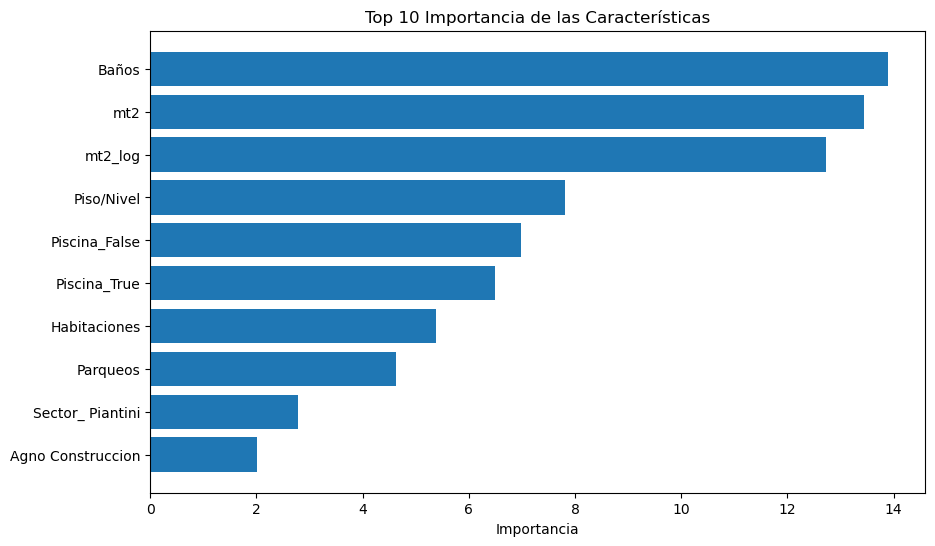

In [34]:
# Seleccionar el mejor modelo basado en RMSE (Test)
best_model_name = min(results, key=lambda x: results[x]['RMSE (Test)'])
print(f"El mejor modelo es: {best_model_name}")

best_model = models[best_model_name]

# Entrenar el mejor modelo con todo el conjunto de datos de entrenamiento
best_model.fit(X_train, y_train)

# Verificar si el modelo tiene importancias de características
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    importances = best_model.named_steps['model'].feature_importances_

    # Obtener los nombres de las características
    feature_names = numeric_features + list(
        preprocessor.named_transformers_['cat'].get_feature_names_out()
    )

    # Ordenar las características por importancia
    feature_importances = sorted(
        zip(feature_names, importances), key=lambda x: x[1], reverse=True
    )

    # Mostrar las 10 características más importantes
    print("Ranking de las 10 variables más importantes:")
    for i, (name, importance) in enumerate(feature_importances[:10]):
        print(f"{i + 1}. {name}: {importance:.4f}")

    # Gráfico de barras para las 10 importancias principales
    plt.figure(figsize=(10, 6))
    plt.barh(
        [x[0] for x in feature_importances[:10]],
        [x[1] for x in feature_importances[:10]]
    )
    plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la más importante primero
    plt.xlabel('Importancia')
    plt.title('Top 10 Importancia de las Características')
    plt.show()

else:
    print("El modelo seleccionado no proporciona importancias de características.")